In [1]:
from itertools import combinations
import re
from tqdm import tqdm
import pandas as pd
import xmltodict
import networkx as nx
import collections
import matplotlib.pyplot as plt
from unidecode import unidecode

In [2]:
def extract_authors(dc):
    if type(dc) == list:
        result = [
            unidecode(i.get("#text").title().strip())
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") != "institution"
        ]
        return [x for x in result if x != "And Others"]
    elif dc.get("#text") is not None and dc.get("@scheme") != "institution":
        return [unidecode(dc.get("#text").title().strip())]


def clean_name(name):
    if ', ' in name:
        lst = name.split(', ')
        lst = [item.split(' ')[0] for item in lst]
        return lst[1] + ' ' + lst[0]
    elif ',' in name:
        lst = name.split(',')
        lst = [item.split(' ')[0] for item in lst]
        return lst[1] + ' ' + lst[0]
    else:
        return name


def get_edges(auth_list):
    return list(combinations(auth_list, 2))

def extract_ids(dc):
    if type(dc) == list:
        return [
            i.get("#text").upper().strip()
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") == "eric_accno"
        ][0]
    elif dc.get("#text") is not None and dc.get("@scheme") == "eric_accno":
        return dc.get("#text").upper().strip()

In [4]:
df_all = []

for year in tqdm(range(2020, 2021)):
    file_name = "data/eric" + str(year)
    with open(file_name + ".xml", encoding="utf-8") as fd:
        dict = xmltodict.parse(fd.read())
    recs = [rec["metadata"] for rec in dict["records"]["record"]]
    df = pd.DataFrame(recs)
    df = df[df['dc:type'].notna()]
    df = df[df['eric:peer_reviewed'].notna()]
    df['type'] = [''.join(map(str, l)).lower() for l in df['dc:type']]
    df = df.loc[df['eric:peer_reviewed'] == 'T']
    # df = df[['ids', 'authors', 'edges', 'dc:type', 'dc:subject', 'eric:keywords', 'eric:keywords_geo', 'dc:title', 'eric:pageCount', 'dc:date', 'eric:dateAdded']]
    df_all.append(df)
df_all = pd.concat(df_all)

df_all = df_all.loc[(df_all['type'].str.contains("journal"))]
df_all["authors"] = df_all.apply(lambda row: extract_authors(row["dc:creator"]), axis=1)
df_all = df_all[df_all['authors'].notna()]
df_all['authors'] = df_all.apply(lambda row: [clean_name(item) for item in row['authors']], axis=1)
df_all["edges"] = df_all.apply(lambda row: get_edges(sorted(row["authors"])), axis=1)
df_all["ids"] = df_all.apply(lambda row: extract_ids(row["dc:identifier"]), axis=1)
df_all.info()

100%|██████████| 1/1 [00:14<00:00, 14.48s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 39676 entries, 364 to 47893
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   dcterms:accessRights       39676 non-null  object
 1   dc:subject                 39676 non-null  object
 2   dc:creator                 39676 non-null  object
 3   dc:type                    39676 non-null  object
 4   eric:keywords_geo          21484 non-null  object
 5   eric:issn                  39638 non-null  object
 6   dc:language                39357 non-null  object
 7   dcterms:educationLevel     26726 non-null  object
 8   dc:description             39676 non-null  object
 9   dc:identifier              39676 non-null  object
 10  dc:title                   39676 non-null  object
 11  dc:source                  39676 non-null  object
 12  eric:citation              39675 non-null  object
 13  dc:date                    39676 non-null  object
 14  eric

In [ ]:
df_all['eric:issue'].values.tolist()

In [ ]:
df_all['authors'] = df_all.apply(lambda row: [clean_name(item) for item in row['authors']], axis=1)

In [ ]:
# l[['dc:date', 'eric:dateAdded']].to_csv("data/all.csv", encoding='utf-8', index=False)

In [ ]:
[item for item in node_list if ', ' not in item]

In [6]:
list1 = df_all["authors"].tolist()
list2 = [x for x in list1 if x is not None]  # remove none
node_list = [item for sublist in list2 for item in sublist]
node_list = list(set(node_list))

In [7]:
list1 = df_all["edges"].tolist()
list2 = [x for x in list1 if x is not None]  # remove none
edge_list = [item for sublist in list2 for item in sublist]

In [8]:
# mean papers per author
len([item for sublist in list2 for item in sublist])/len(node_list)

1.8647175300070893

In [9]:
G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 81814\nNumber of edges: 143032\nAverage degree:   3.4965'

In [ ]:
nx.degree_histogram(G)

In [ ]:
# nx.write_edgelist(G, "all.edgelist.gz")

In [ ]:
# G = nx.read_edgelist("all.edgelist.gz")

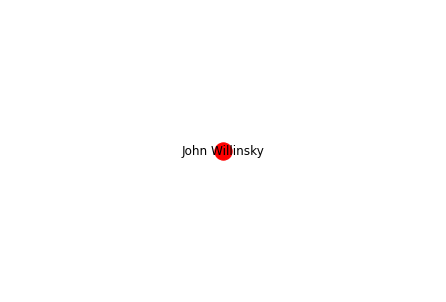

In [36]:
hub_ego = nx.ego_graph(G, "John Willinsky")
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=True)
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=["John Willinsky"], **options)

In [35]:
[s for s in node_list if "Willinsky" in s]

['John Willinsky']